In [43]:

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = ".."
CONFIG_DIR = os.path.join(BASE_DIR, "config")
QUALITY_DIR = os.path.join(BASE_DIR, "quality")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

AGENT_COUNTS = [2, 3, 5, 10, 20]
NUM_SAMPLES_PER_COMBINATION = 20

BID_COMBO_LABELS = {
    2: [
        ("0.00/0.00", "Base Only"),
        ("0.50/0.50", "Equal Split 0.50"),
        ("0.30/0.70", "Dominant 0.70"),
        ("0.10/0.90", "Dominant 0.90"),
        ("1.00/0.00", "Monopoly 1.00"),
    ],
    3: [
        ("0.00/0.00/0.00", "Base Only"),
        ("0.33/0.33/0.33", "Equal Split 0.33"),
        ("0.40/0.40/0.20", "Two Dominant 0.40"),
        ("0.50/0.50/0.00", "Two Dominant 0.50"),
        ("0.50/0.30/0.20", "Dominant 0.50"),
        ("0.60/0.30/0.10", "Dominant 0.60"),
        ("0.60/0.20/0.20", "Dominant 0.60"),
        ("1.00/0.00/0.00", "Monopoly 1.00"),
    ],
    5: [
        ("0.00/0.00/0.00/0.00/0.00", "Base Only"),
        ("0.20/0.20/0.20/0.20/0.20", "Equal Split 0.20"),
        ("0.25/0.25/0.25/0.15/0.10", "Three Dominant 0.25"),
        ("0.30/0.30/0.20/0.10/0.10", "Two Dominant 0.30"),
        ("0.40/0.30/0.20/0.05/0.05", "Dominant 0.40"),
        ("0.50/0.25/0.15/0.07/0.03", "Dominant 0.50"),
        ("0.60/0.20/0.10/0.05/0.05", "Dominant 0.60"),
        ("1.00/0.00/0.00/0.00/0.00", "Monopoly 1.00"),
    ],
    10: [
        ("0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00", "Base Only"),
        ("0.10/0.10/0.10/0.10/0.10/0.10/0.10/0.10/0.10/0.10", "Equal Split 0.10"),
        ("0.20/0.20/0.20/0.15/0.10/0.05/0.05/0.03/0.01/0.01", "Three Dominant 0.20"),
        ("0.25/0.20/0.15/0.12/0.10/0.08/0.05/0.03/0.01/0.01", "Dominant 0.25"),
        ("0.30/0.20/0.15/0.12/0.10/0.07/0.04/0.01/0.00/0.01", "Dominant 0.30"),
        ("0.35/0.15/0.12/0.10/0.08/0.07/0.05/0.04/0.02/0.02", "Dominant 0.35"),
        ("1.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00", "Monopoly 1.00"),
    ],
    20: [
        ("0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00", "Base Only"),
        ("0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05/0.05", "Equal Split 0.05"),
        ("0.10/0.10/0.10/0.10/0.08/0.08/0.08/0.07/0.07/0.07/0.05/0.05/0.05/0.02/0.02/0.02/0.01/0.01/0.01/0.01", "Four Dominant 0.10"),
        ("0.15/0.12/0.10/0.08/0.07/0.06/0.05/0.05/0.04/0.04/0.03/0.03/0.02/0.02/0.02/0.01/0.01/0.01/0.01/0.01", "Dominant 0.15"),
        ("0.20/0.12/0.10/0.08/0.07/0.06/0.05/0.04/0.03/0.03/0.03/0.02/0.02/0.02/0.01/0.01/0.01/0.01/0.01/0.01", "Dominant 0.20"),
        ("1.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00/0.00", "Monopoly 1.00"),
    ],
}

def get_bid_combo_order(num_agents: int) -> List[str]:
    """Get ordered list of bid combinations to include."""
    if num_agents in BID_COMBO_LABELS:
        return [combo for combo, label in BID_COMBO_LABELS[num_agents]]
    return None  # None means include all

def get_bid_combo_label(bid_combo: str, num_agents: int) -> str:
    """Get display label for a bid combination."""
    if num_agents in BID_COMBO_LABELS:
        for combo, label in BID_COMBO_LABELS[num_agents]:
            if combo == bid_combo:
                return label
    return bid_combo  # Fallback to original

def load_config(num_agents: int) -> Dict:
    """Load quality_laion config for a specific agent count."""
    config_path = os.path.join(CONFIG_DIR, f"quality_laion_config_{num_agents}_agents.json")
    with open(config_path, 'r') as f:
        return json.load(f)

def get_bidding_combinations(config: Dict, include_all_zeros: bool = True) -> List[List[float]]:
    """Get bidding combinations from config."""
    combos = config.get("bidding_combinations", [])
    if not include_all_zeros:
        combos = [c for c in combos if sum(c) > 0]
    return combos

def construct_quality_filename(prompt_idx: int, bids: List[float], sample_idx: int) -> str:
    """Construct the quality JSON filename."""
    bid_str = "_".join([f"{bid:.2f}" for bid in bids])
    return f"quality_p{prompt_idx:03d}_b{bid_str}_s{sample_idx:02d}.json"

print("Configuration loaded. Agent counts:", AGENT_COUNTS)


Configuration loaded. Agent counts: [2, 3, 5, 10, 20]


In [44]:
def load_quality_data_for_agents(num_agents: int, max_prompts: int = 200) -> Tuple[pd.DataFrame, int]:
    """
    Load LAION quality data for a specific agent count.
    Only includes prompts that have complete data (all combinations x all samples).
    Returns: (DataFrame, number of complete prompts used)
    """
    config = load_config(num_agents)
    bidding_combinations = get_bidding_combinations(config, include_all_zeros=True)
    quality_dir = os.path.join(QUALITY_DIR, f"quality_laion_{num_agents}_agents")
    
    all_data = []
    complete_prompts = 0
    
    for prompt_idx in range(max_prompts):
        prompt_dir = os.path.join(quality_dir, f"prompt_{prompt_idx:03d}")
        if not os.path.exists(prompt_dir):
            continue
        
        prompt_data = []
        is_complete = True
        
        for bids in bidding_combinations:
            for sample_idx in range(NUM_SAMPLES_PER_COMBINATION):
                filename = construct_quality_filename(prompt_idx, bids, sample_idx)
                filepath = os.path.join(prompt_dir, filename)
                
                if not os.path.exists(filepath):
                    is_complete = False
                    break
                
                try:
                    with open(filepath, 'r') as f:
                        sample_data = json.load(f)
                    
                    row = {
                        'prompt': sample_data['metadata']['prompt_index'],
                        'sample': sample_data['metadata']['sample_index'],
                        'aesthetic_score': sample_data['quality_assessment']['aesthetic_score'],
                    }
                    
                    # Add bid columns
                    for i, bid in enumerate(bids):
                        row[f'bid_{i+1}'] = bid
                    
                    # Check if all bids are zero (base prompt only)
                    row['is_base_only'] = all(b == 0 for b in bids)
                    
                    prompt_data.append(row)
                except Exception as e:
                    is_complete = False
                    break
            
            if not is_complete:
                break
        
        if is_complete and len(prompt_data) == len(bidding_combinations) * NUM_SAMPLES_PER_COMBINATION:
            all_data.extend(prompt_data)
            complete_prompts += 1
    
    df = pd.DataFrame(all_data) if all_data else pd.DataFrame()
    return df, complete_prompts

# Load quality data for all agent counts
quality_data = {}
for n_agents in AGENT_COUNTS:
    df, n_prompts = load_quality_data_for_agents(n_agents)
    quality_data[n_agents] = df
    print(f"{n_agents} agents: {n_prompts} complete prompts, {len(df)} total rows")

print("\nData loading complete!")


2 agents: 200 complete prompts, 32000 total rows
3 agents: 133 complete prompts, 26600 total rows
5 agents: 85 complete prompts, 13600 total rows
10 agents: 44 complete prompts, 6160 total rows
20 agents: 25 complete prompts, 3000 total rows

Data loading complete!


In [45]:
# Create output directories
for n_agents in AGENT_COUNTS:
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    os.makedirs(output_dir, exist_ok=True)
print("Output directories created.")


Output directories created.


=== 2-Agent Quality Line Graph ===

Saved: ../results/2_agents/laion_quality_line_2_agents.png
Saved: ../results/2_agents/laion_quality_line_2_agents.csv


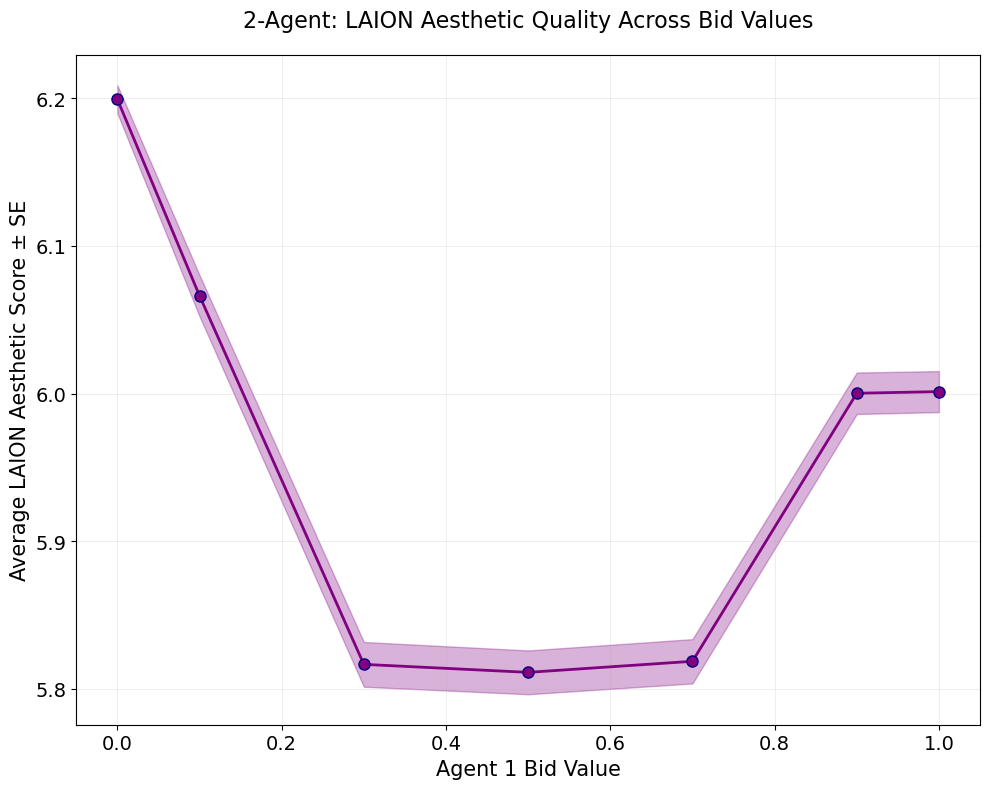

In [46]:
def plot_quality_line_2_agents(df: pd.DataFrame, save_path: str = None):
    """
    Plot LAION aesthetic quality scores as a line graph for 2-agent setting.
    Shows how quality changes with Agent 1's bid value.
    Replicates the style from calculate_welfare_2_agent_old.ipynb
    Also saves a CSV with the statistics.
    """
    if df.empty or 'bid_1' not in df.columns:
        print("No 2-agent data available")
        return None
    
    # Group by bid_1 and calculate statistics
    quality_stats = df.groupby('bid_1')['aesthetic_score'].agg(['mean', 'std', 'count']).reset_index()
    quality_stats['se'] = quality_stats['std'] / np.sqrt(quality_stats['count'])
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Plot quality vs bid_1
    ax.plot(quality_stats['bid_1'], quality_stats['mean'], 'o-', linewidth=2, markersize=8,
            color='purple', markeredgecolor='navy', markeredgewidth=1)
    ax.fill_between(quality_stats['bid_1'],
                    quality_stats['mean'] - quality_stats['se'],
                    quality_stats['mean'] + quality_stats['se'],
                    alpha=0.3, color='purple')
    
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Agent 1 Bid Value', fontsize=15)
    ax.set_ylabel('Average LAION Aesthetic Score ± SE', fontsize=15)
    ax.set_title('2-Agent: LAION Aesthetic Quality Across Bid Values', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_xlim(-0.05, 1.05)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        # Save CSV with statistics
        csv_path = save_path.replace('.png', '.csv')
        csv_df = quality_stats[['bid_1', 'mean', 'std', 'se', 'count']].copy()
        csv_df.columns = ['agent_1_bid', 'mean', 'std', 'se', 'count']
        csv_df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")
    
    return plt

# Generate 2-agent quality line plot
print("=== 2-Agent Quality Line Graph ===\n")

if 2 in quality_data and not quality_data[2].empty:
    output_dir = os.path.join(RESULTS_DIR, "2_agents")
    save_path = os.path.join(output_dir, "laion_quality_line_2_agents.png")
    
    plot_quality_line_2_agents(quality_data[2], save_path=save_path)
    plt.show()
    plt.close()
else:
    print("No 2-agent quality data available")


In [47]:
def get_bid_columns(num_agents: int) -> List[str]:
    """Get list of bid column names."""
    return [f'bid_{i+1}' for i in range(num_agents)]

def plot_quality_bar_n_agents(df: pd.DataFrame, num_agents: int, save_path: str = None):
    """
    Plot LAION aesthetic quality scores as a bar chart for N agents.
    Shows quality for each bid combination as defined in BID_COMBO_LABELS.
    Uses display labels for x-axis and maintains specified order.
    Also saves a CSV with the statistics.
    """
    if df.empty:
        print(f"No data for {num_agents} agents")
        return None
    
    bid_cols = get_bid_columns(num_agents)
    
    # Create bid combination label
    df = df.copy()
    df['bid_combo'] = df.apply(
        lambda r: '/'.join([f"{r[f'bid_{i+1}']:.2f}" for i in range(num_agents)]), axis=1
    )
    
    # Filter by BID_COMBO_LABELS if defined
    combo_order = get_bid_combo_order(num_agents)
    if combo_order:
        df = df[df['bid_combo'].isin(combo_order)]
    
    # Calculate statistics per bid combination
    stats = df.groupby('bid_combo')['aesthetic_score'].agg(['mean', 'std', 'count']).reset_index()
    stats['se'] = stats['std'] / np.sqrt(stats['count'])
    
    # Order stats according to BID_COMBO_LABELS
    if combo_order:
        stats['order'] = stats['bid_combo'].apply(lambda x: combo_order.index(x) if x in combo_order else 999)
        stats = stats.sort_values('order').drop('order', axis=1)
    
    # Get display labels
    stats['display_label'] = stats['bid_combo'].apply(lambda x: get_bid_combo_label(x, num_agents))
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # All bars same color (steelblue)
    bars = ax.bar(range(len(stats)), stats['mean'], yerr=stats['se'], capsize=4,
                  alpha=0.8, color='steelblue', edgecolor='navy', linewidth=1.2)
    
    ax.set_xticks(range(len(stats)))
    ax.set_xticklabels(stats['display_label'], rotation=45, ha='right', fontsize=11)
    ax.set_xlabel(f'Bid Combination ({num_agents} agents)', fontsize=14)
    ax.set_ylabel('Mean LAION Aesthetic Score ± SE', fontsize=14)
    ax.set_title(f'{num_agents}-Agent: LAION Aesthetic Quality by Bid Combination', fontsize=16, pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        # Save CSV with statistics
        csv_path = save_path.replace('.png', '.csv')
        csv_df = stats[['bid_combo', 'display_label', 'mean', 'std', 'se', 'count']].copy()
        csv_df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")
    
    return plt


=== Generating Quality Bar Plots for All Agent Settings ===

Saved: ../results/2_agents/laion_quality_bar_2_agents.png
Saved: ../results/2_agents/laion_quality_bar_2_agents.csv


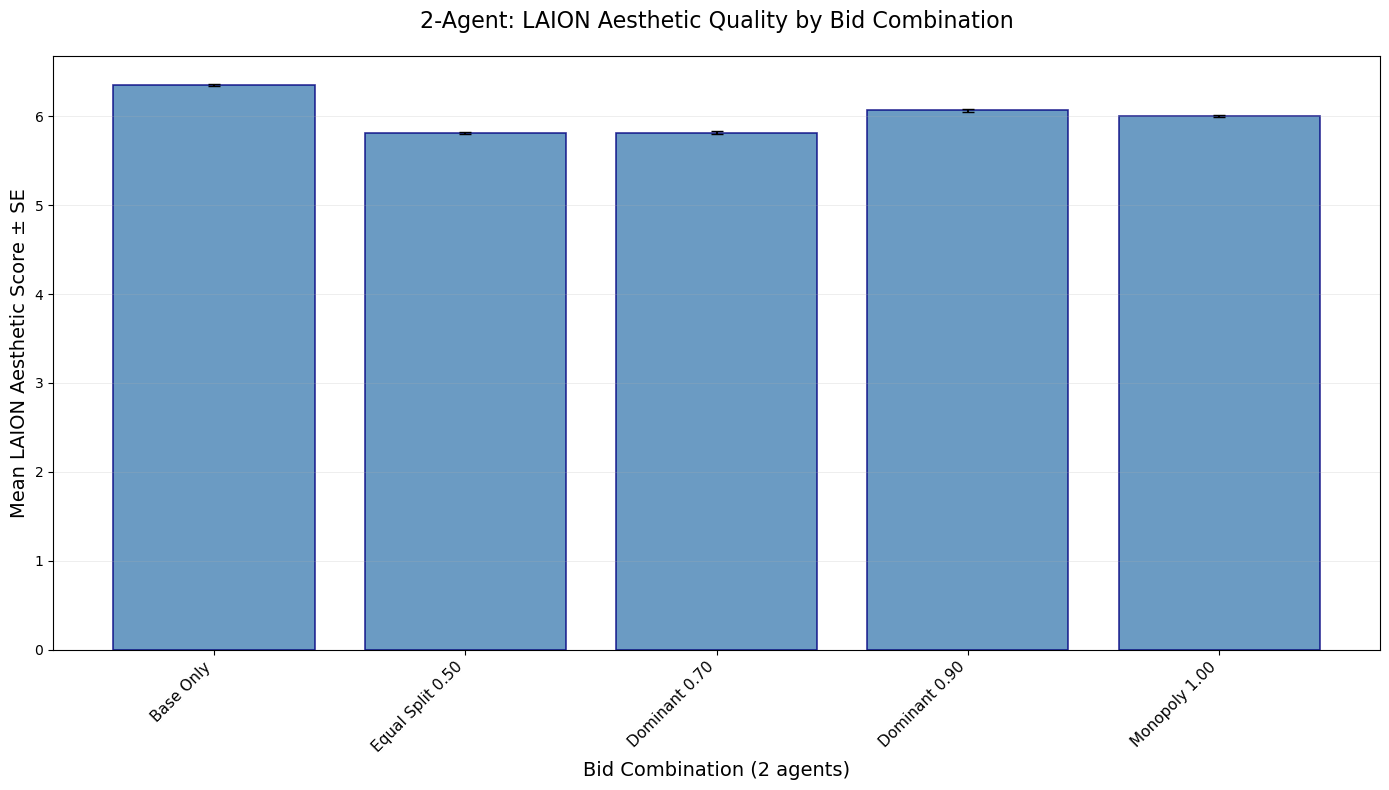

Saved: ../results/3_agents/laion_quality_bar_3_agents.png
Saved: ../results/3_agents/laion_quality_bar_3_agents.csv


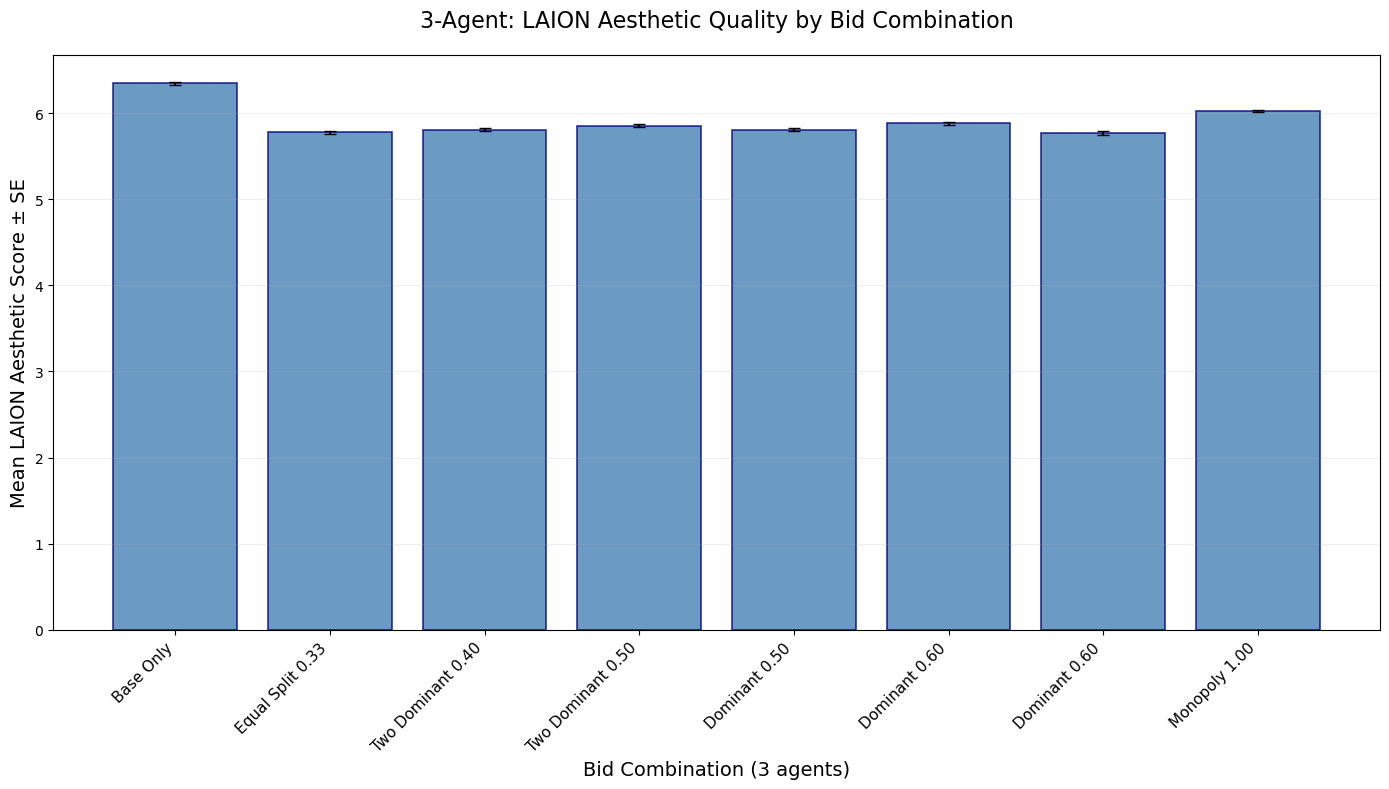

Saved: ../results/5_agents/laion_quality_bar_5_agents.png
Saved: ../results/5_agents/laion_quality_bar_5_agents.csv


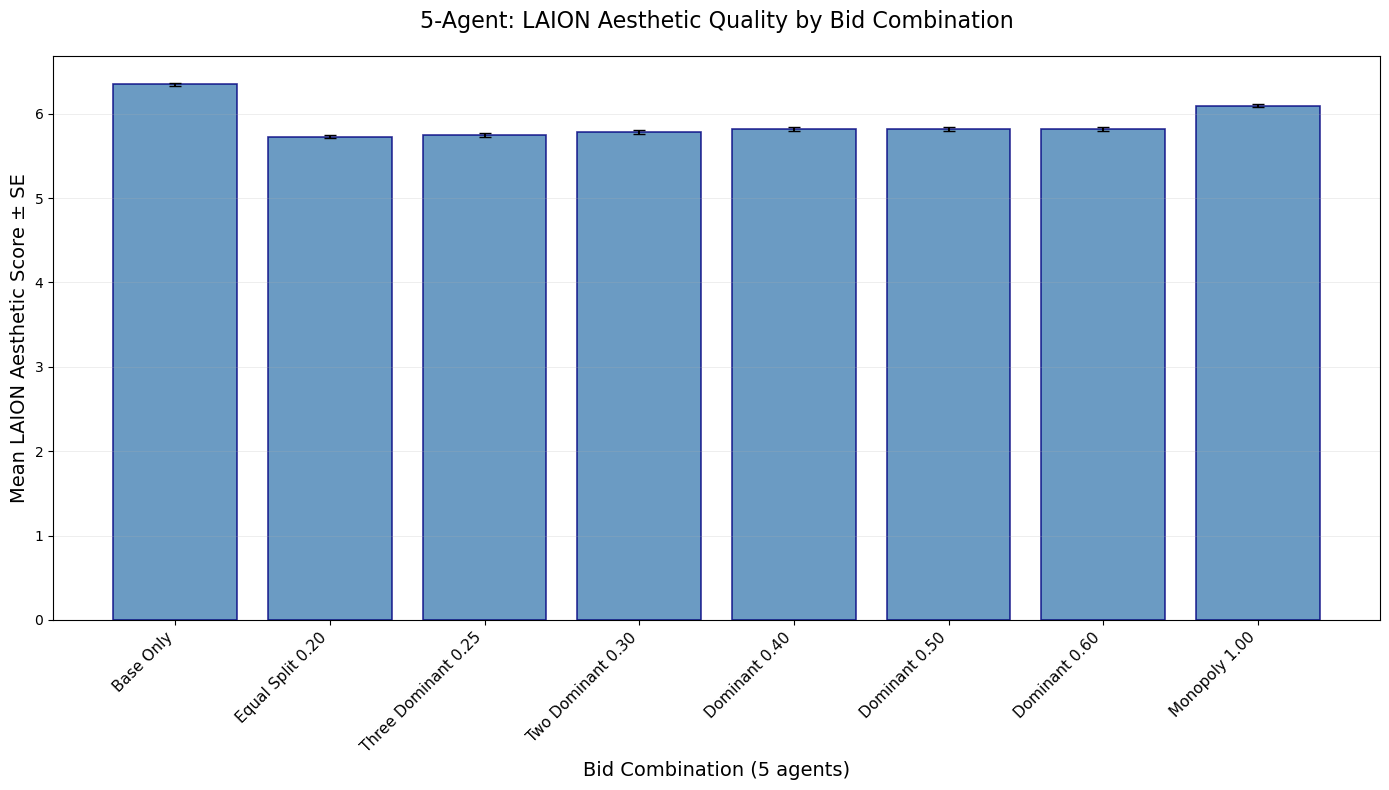

Saved: ../results/10_agents/laion_quality_bar_10_agents.png
Saved: ../results/10_agents/laion_quality_bar_10_agents.csv


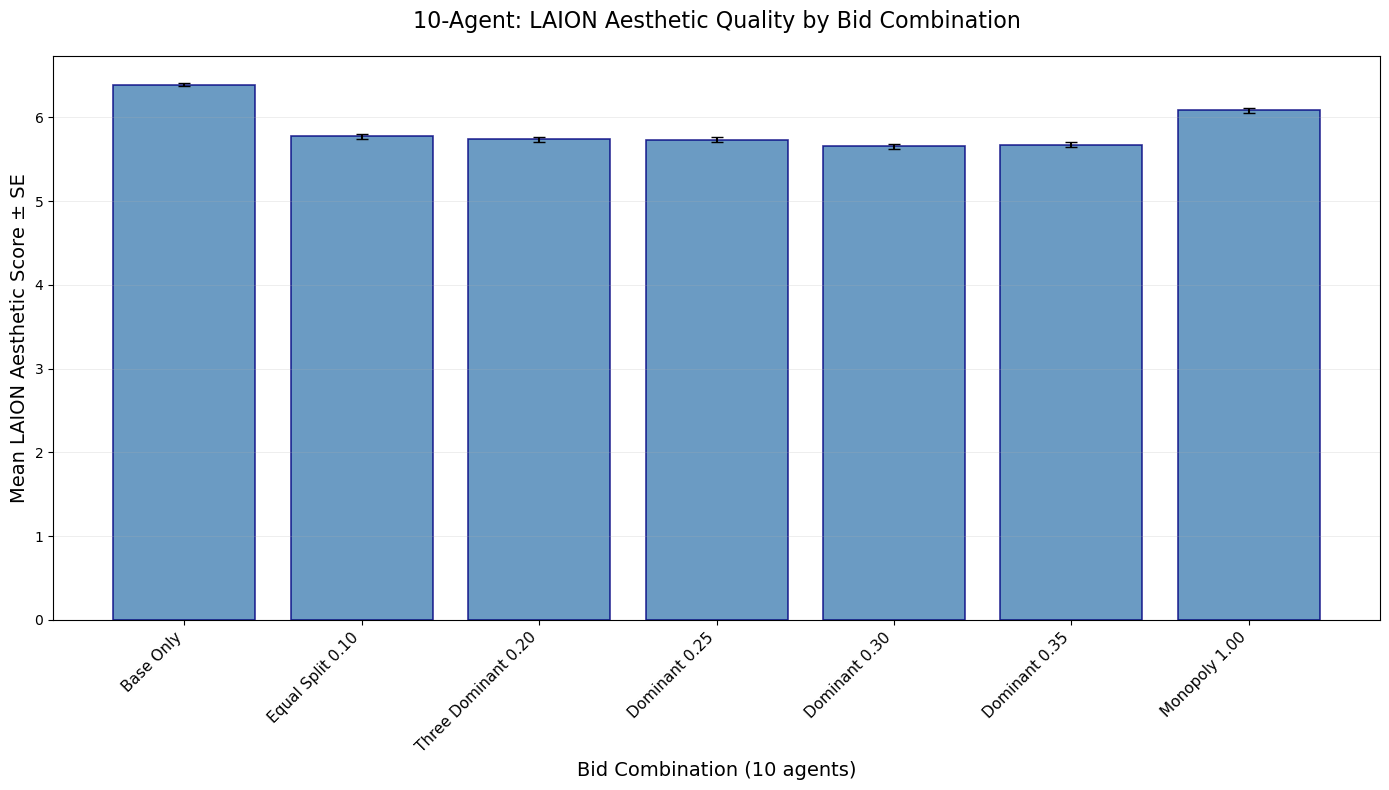

Saved: ../results/20_agents/laion_quality_bar_20_agents.png
Saved: ../results/20_agents/laion_quality_bar_20_agents.csv


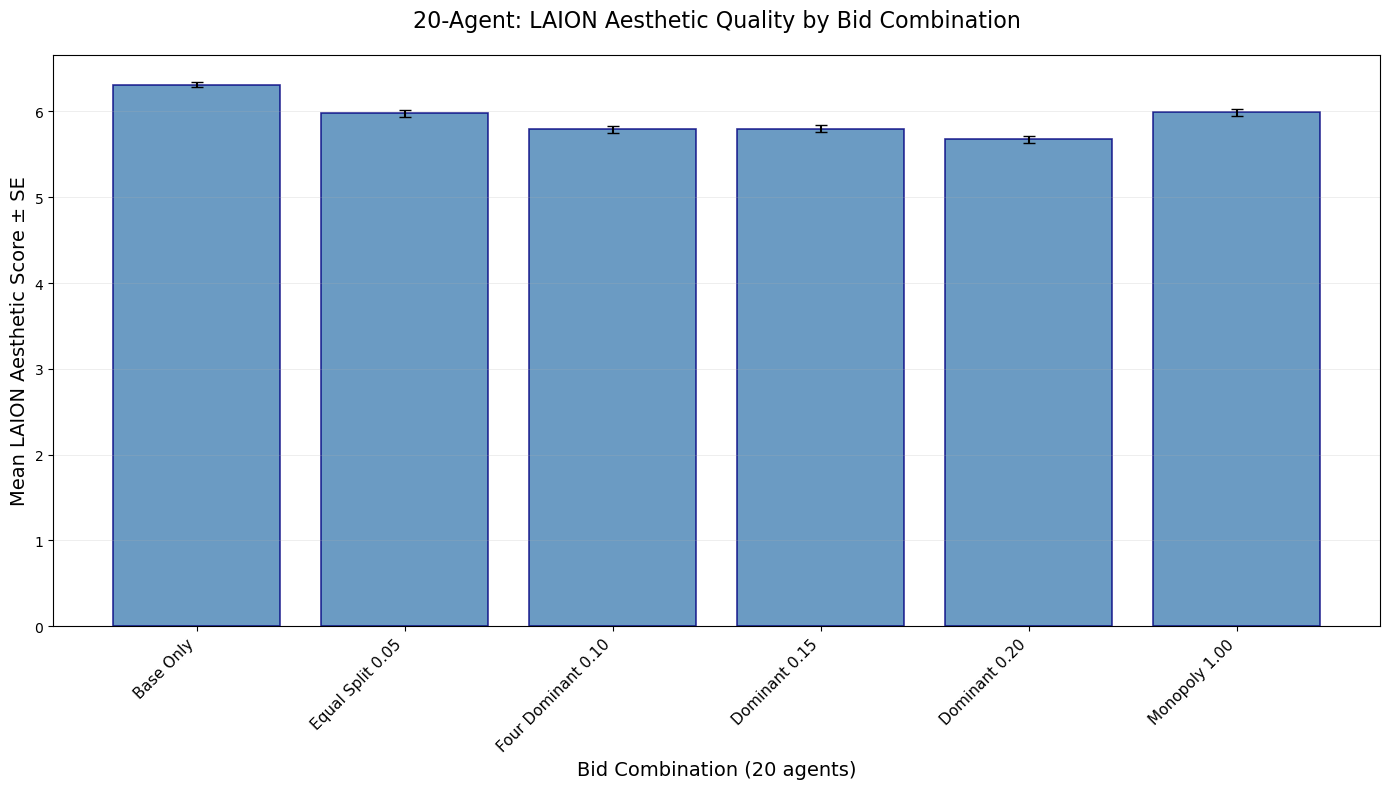

In [48]:
# Generate quality bar plots for all agent settings
print("=== Generating Quality Bar Plots for All Agent Settings ===\n")

for n_agents in AGENT_COUNTS:
    if n_agents not in quality_data or quality_data[n_agents].empty:
        print(f"Skipping {n_agents} agents (no data)")
        continue
    
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    save_path = os.path.join(output_dir, f"laion_quality_bar_{n_agents}_agents.png")
    
    plot_quality_bar_n_agents(quality_data[n_agents], n_agents, save_path=save_path)
    plt.show()
    plt.close()


In [49]:
# Summary statistics
print("=== Summary Statistics ===\n")

for n_agents in AGENT_COUNTS:
    if n_agents in quality_data and not quality_data[n_agents].empty:
        df = quality_data[n_agents]
        
        # Overall stats
        print(f"\n{n_agents} Agents:")
        print(f"  Overall mean aesthetic score: {df['aesthetic_score'].mean():.3f}")
        print(f"  Overall std aesthetic score: {df['aesthetic_score'].std():.3f}")
        
        # Base prompt vs with agents
        base_only = df[df['is_base_only'] == True]['aesthetic_score']
        with_agents = df[df['is_base_only'] == False]['aesthetic_score']
        
        if len(base_only) > 0:
            print(f"  Base prompt only mean: {base_only.mean():.3f}")
        if len(with_agents) > 0:
            print(f"  With agent prompts mean: {with_agents.mean():.3f}")
            if len(base_only) > 0:
                diff = with_agents.mean() - base_only.mean()
                print(f"  Difference (agents - base): {diff:.3f}")
    else:
        print(f"\n{n_agents} Agents: No data available")


=== Summary Statistics ===


2 Agents:
  Overall mean aesthetic score: 5.989
  Overall std aesthetic score: 0.912
  Base prompt only mean: 6.349
  With agent prompts mean: 5.938
  Difference (agents - base): -0.412

3 Agents:
  Overall mean aesthetic score: 5.939
  Overall std aesthetic score: 0.920
  Base prompt only mean: 6.344
  With agent prompts mean: 5.894
  Difference (agents - base): -0.450

5 Agents:
  Overall mean aesthetic score: 5.896
  Overall std aesthetic score: 0.911
  Base prompt only mean: 6.351
  With agent prompts mean: 5.831
  Difference (agents - base): -0.520

10 Agents:
  Overall mean aesthetic score: 5.863
  Overall std aesthetic score: 0.899
  Base prompt only mean: 6.391
  With agent prompts mean: 5.775
  Difference (agents - base): -0.616

20 Agents:
  Overall mean aesthetic score: 5.924
  Overall std aesthetic score: 0.877
  Base prompt only mean: 6.312
  With agent prompts mean: 5.847
  Difference (agents - base): -0.466


In [50]:
print("\n=== All LAION quality plots generated! ===")
print("\nOutput files saved to:")
for n_agents in AGENT_COUNTS:
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    if os.path.exists(output_dir):
        files = [f for f in os.listdir(output_dir) if f.startswith('laion_') and f.endswith('.png')]
        if files:
            print(f"\n{n_agents} agents:")
            for f in files:
                print(f"  - {f}")



=== All LAION quality plots generated! ===

Output files saved to:

2 agents:
  - laion_quality_line_2_agents.png
  - laion_quality_bar_2_agents.png

3 agents:
  - laion_quality_bar_3_agents.png

5 agents:
  - laion_quality_bar_5_agents.png

10 agents:
  - laion_quality_bar_10_agents.png

20 agents:
  - laion_quality_bar_20_agents.png
